## Chapter 10 - Model Comparision and Hierarchical Modelling

- [10.3.2 - Hierarchical MCMC computation of relative model probability (Two factories of coins)](#10.3.2---Hierarchical-MCMC-computation-of-relative-model-probability)
 - [Model 1 - One theta variable ](#Model-1---One-theta-variable)
 - [Model 2 - Two theta variables without pseudo priors](#Model-2---Two-theta-variables-without-pseudo-priors)
 - [Model 3 - Two theta variables with pseudo priors = true prior](#Model-3---Two-theta-variables-with-pseudo-priors-=-true-prior)
 - [Model 4 - Two theta variables with pseudo priors that mimic posteriors ](#Model-4---Two-theta-variables-with-pseudo-priors-that-mimic-posteriors)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from IPython.display import Image
from matplotlib import gridspec

plt.style.use('seaborn-white')

color = '#87ceeb'

In [40]:
%load_ext watermark
%watermark -p matplotlib,numpy,pandas,pymc,seaborn

matplotlib: 3.5.1
numpy     : 1.23.1
pandas    : 1.4.3
pymc      : 5.0.0
seaborn   : 0.12.2



### 10.3.2 - Hierarchical MCMC computation of relative model probability

#### Model (Kruschke, 2015)

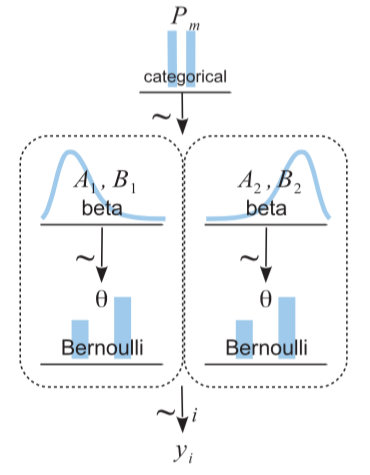

In [5]:
Image('images/fig10_2.png', width=300)

### Model 1 - One theta variable 
Coin is flipped nine times, resulting in six heads.

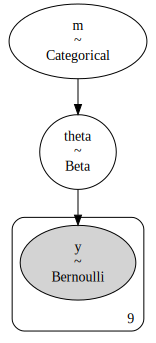

In [7]:
with pm.Model() as hierarchical_model:
    m = pm.Categorical("m", np.asarray([0.5, 0.5]))

    kappa = 12

    omega = pm.math.switch(pm.math.eq(m, 0), 0.25, 0.75)

    theta = pm.Beta("theta", omega * (kappa - 2) + 1, (1 - omega) * (kappa - 2) + 1)

    y = pm.Bernoulli("y", theta, observed=[1, 1, 1, 1, 1, 1, 0, 0, 0])

pm.model_to_graphviz(hierarchical_model)

In [8]:
with hierarchical_model:
    idata = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta]
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2 seconds.


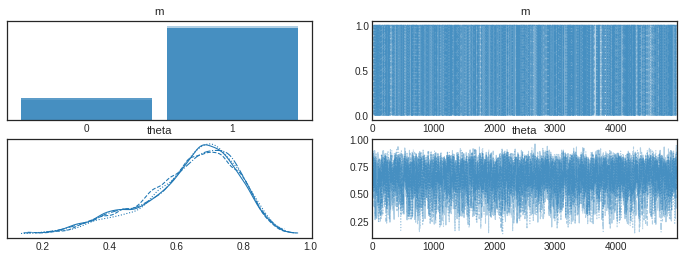

In [10]:
az.plot_trace(idata);

In [11]:
trace_df = idata.posterior.to_dataframe().set_index('m')
trace_df.head()

,theta
m,
1,0.632741
1,0.707682
1,0.646527
1,0.737590
1,0.668324


#### Figure 10.4 (lower frame)
Note that the models are indexed starting with 0 and not 1, as is the case in Kruschke (2015). So the posterior mean of parameter `m` is shifted with -1.

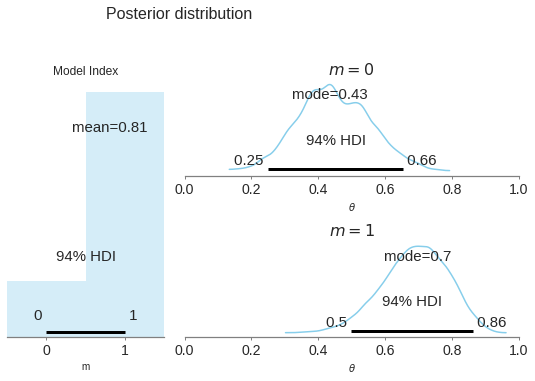

In [13]:
fig = plt.figure(figsize=(10, 5))

font_d = {"size": 16}

# Define gridspec
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:, 1])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 2:])

# Distplot m
az.plot_posterior(np.asarray(trace_df.index), ax=ax1, color=color)
ax1.set_xlabel("m")
ax1.set_title("Model Index")

# Distplot theta for m=0 and m=1
for model, ax in zip((0, 1), (ax2, ax3)):
    az.plot_posterior(
        trace_df.loc[model].values.ravel(), point_estimate="mode", ax=ax, color=color
    )
    ax.set_title(r"$m = {}$".format(model), fontdict=font_d)
    ax.set(xlim=(0, 1), xlabel=r"$\theta$")

fig.suptitle("Posterior distribution", size=16, y=1.05)

fig.tight_layout()

### Model 2 - Two theta variables without pseudo priors
Coin is flipped nine times, resulting in six heads.

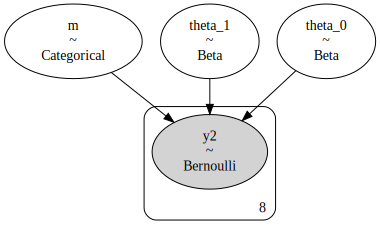

In [15]:
with pm.Model() as hierarchical_model2:
    m = pm.Categorical("m", np.asarray([0.5, 0.5]))

    omega_0 = 0.25
    kappa_0 = 12
    theta_0 = pm.Beta(
        "theta_0", omega_0 * (kappa_0 - 2) + 1, (1 - omega_0) * (kappa_0 - 2) + 1
    )

    omega_1 = 0.75
    kappa_1 = 12
    theta_1 = pm.Beta(
        "theta_1", omega_1 * (kappa_1 - 2) + 1, (1 - omega_1) * (kappa_1 - 2) + 1
    )

    theta = pm.math.switch(pm.math.eq(m, 0), theta_0, theta_1)

    y2 = pm.Bernoulli("y2", theta, observed=[1, 1, 1, 1, 1, 0, 0, 0])

pm.model_to_graphviz(hierarchical_model2)

In [16]:
with hierarchical_model2:
    idata2 = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


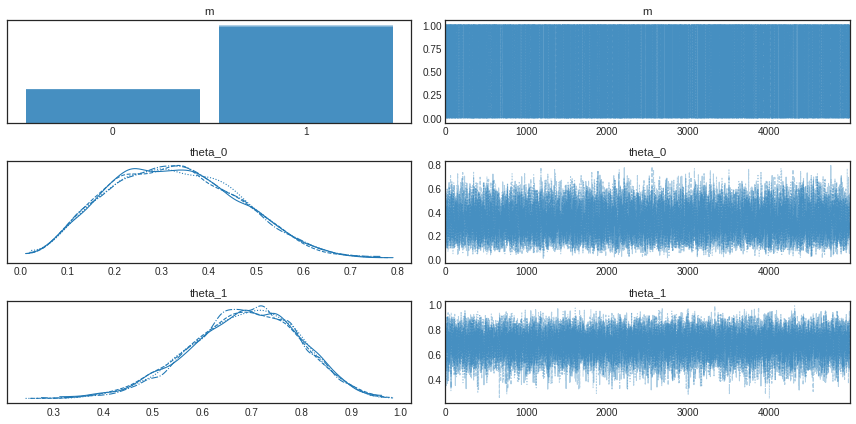

In [18]:
az.plot_trace(idata2)
plt.tight_layout();

### Model 3 - Two theta variables with pseudo priors = true prior
Coin is flipped 30 times, resulting in 17 heads.

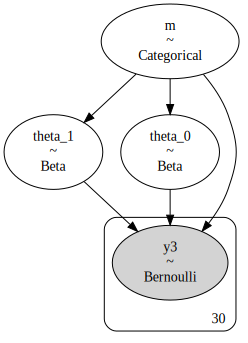

In [25]:
with pm.Model() as hierarchical_model3:
    m = pm.Categorical("m", np.asarray([0.5, 0.5]))

    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 20
    kappa_0 = pm.math.switch(pm.math.eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = 0.10
    omega_0_pseudo_p = 0.10
    omega_0 = pm.math.switch(pm.math.eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta(
        "theta_0", omega_0 * (kappa_0 - 2) + 1, (1 - omega_0) * (kappa_0 - 2) + 1
    )

    # Theta1
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 20
    kappa_1 = pm.math.switch(pm.math.eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = 0.90
    omega_1_pseudo_p = 0.90
    omega_1 = pm.math.switch(pm.math.eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta(
        "theta_1", omega_1 * (kappa_1 - 2) + 1, (1 - omega_1) * (kappa_1 - 2) + 1
    )

    theta = pm.math.switch(pm.math.eq(m, 0), theta_0, theta_1)

    y3 = pm.Bernoulli("y3", theta, observed=np.array(17 * [1] + 13 * [0]))

pm.model_to_graphviz(hierarchical_model3)

In [28]:
with hierarchical_model3:
    idata3 = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


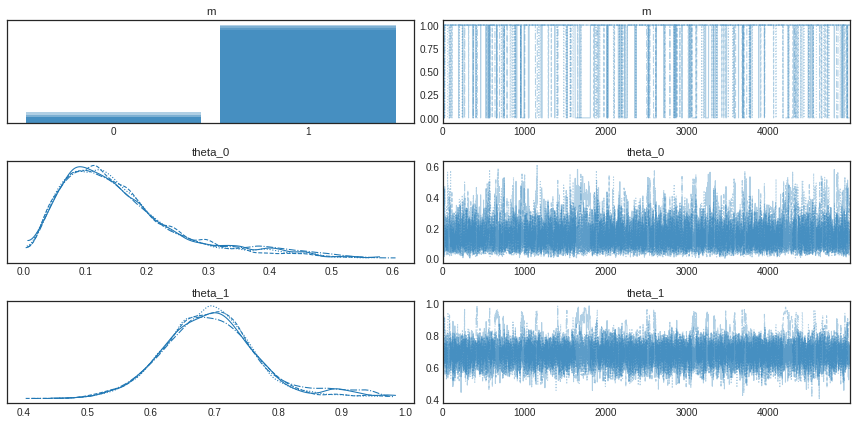

In [30]:
az.plot_trace(idata3)
plt.tight_layout();

In [31]:
trace3_df = idata3.posterior.to_dataframe().set_index('m')[['theta_0', 'theta_1']]
trace3_df.head()

,theta_0,theta_1
m,,
1,0.243821,0.628268
1,0.129705,0.794043
1,0.100217,0.716958
1,0.175543,0.825905
1,0.071940,0.585135


#### Figure 10.5 (lower part)

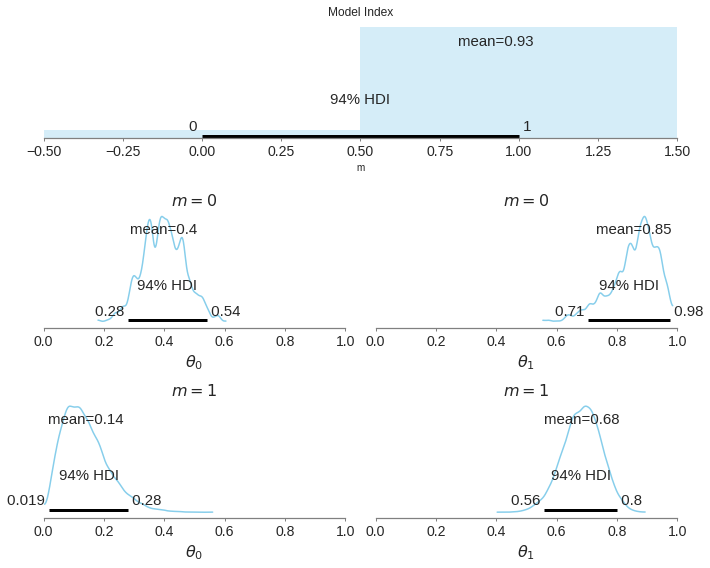

In [32]:
fig = plt.figure(figsize=(10, 8))

# Define gridspec
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

az.plot_posterior(np.asarray(trace3_df.index), ax=ax1, color=color)
ax1.set_xlabel("m")
ax1.set_title("Model Index")

for model, theta, ax in zip((0, 0, 1, 1), (0, 1, 0, 1), (ax2, ax3, ax4, ax5)):
    az.plot_posterior(
        trace3_df.loc[model, "theta_{}".format(theta)].values, ax=ax, color=color
    )
    ax.set_title(r"$m = {}$".format(model), fontdict=font_d)
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$\theta_{}$".format(theta), fontdict=font_d)

fig.tight_layout()

### Model 4 - Two theta variables with pseudo priors that mimic posteriors 
Coin is flipped 30 times, resulting in 17 heads.

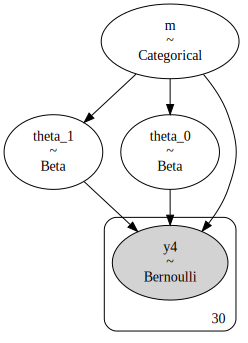

In [33]:
with pm.Model() as hierarchical_model4:
    m = pm.Categorical("m", np.asarray([0.5, 0.5]))

    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 50
    kappa_0 = pm.math.switch(pm.math.eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = 0.10
    omega_0_pseudo_p = 0.40
    omega_0 = pm.math.switch(pm.math.eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta(
        "theta_0", omega_0 * (kappa_0 - 2) + 1, (1 - omega_0) * (kappa_0 - 2) + 1
    )

    # Theta1
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 50
    kappa_1 = pm.math.switch(pm.math.eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = 0.90
    omega_1_pseudo_p = 0.70
    omega_1 = pm.math.switch(pm.math.eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta(
        "theta_1", omega_1 * (kappa_1 - 2) + 1, (1 - omega_1) * (kappa_1 - 2) + 1
    )

    theta = pm.math.switch(pm.math.eq(m, 0), theta_0, theta_1)

    y4 = pm.Bernoulli("y4", theta, observed=np.array(17 * [1] + 13 * [0]))

pm.model_to_graphviz(hierarchical_model4)

In [34]:
with hierarchical_model4:
    idata4 = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


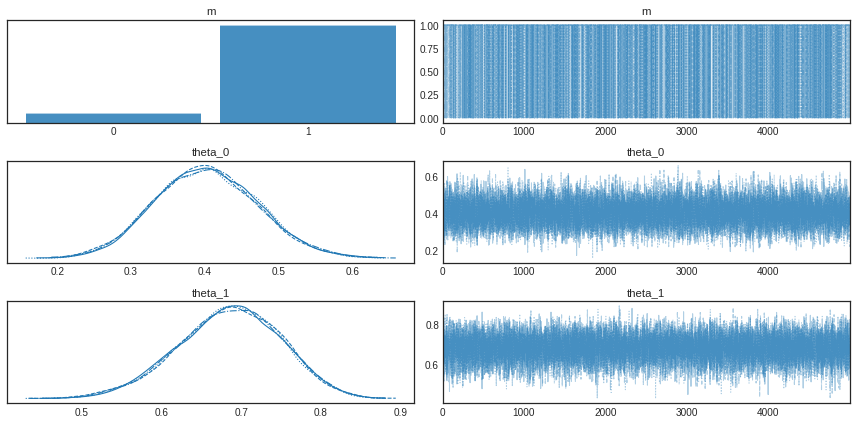

In [35]:
az.plot_trace(idata4)
plt.tight_layout();

In [36]:
trace4_df = idata4.posterior.to_dataframe().set_index('m')[['theta_0', 'theta_1']]
trace4_df.head()

,theta_0,theta_1
m,,
1,0.441916,0.637910
1,0.360125,0.623515
1,0.378674,0.707968
1,0.427565,0.680831
1,0.335518,0.812215


#### Figure 10.6 (lower part)

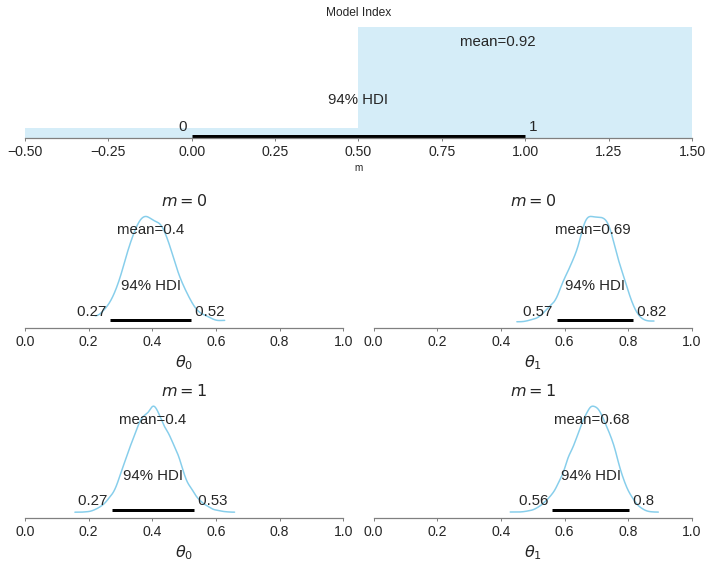

In [37]:
fig = plt.figure(figsize=(10,8))

# Define gridspec
gs = gridspec.GridSpec(3,2)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

az.plot_posterior(np.asarray(trace4_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

for model, theta, ax in zip((0,0,1,1), (0,1,0,1), (ax2, ax3, ax4, ax5)):
    az.plot_posterior(trace4_df.loc[model, 'theta_{}'.format(theta)].values, ax=ax, color=color)
    ax.set_title(r'$m = {}$'.format(model), fontdict=font_d)
    ax.set_xlim(0,1)
    ax.set_xlabel(r'$\theta_{}$'.format(theta), fontdict=font_d)
    
fig.tight_layout();